In [1]:
# IMPORTS
import os
import pickle
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import utils as ut
from config import CLUSTER_NAMES, COUNTRIES, PATH_CLUSTERS, PATH_DATA, PATH_ED, REGIONS, VERSION
from matplotlib import cm, gridspec
from scipy.cluster.hierarchy import fcluster, linkage
from tqdm.notebook import tqdm

In [2]:
co_occurrence_dict = pickle.load(
    open(os.path.join(PATH_DATA, VERSION, "co_occurrence_dict.pickle"), "rb"),
)

DF_CO_OCCURRENCES_FILENAME = os.path.join(PATH_DATA, VERSION, "df_co_occurrences.csv")
co_occur_counts_df = pd.read_csv(DF_CO_OCCURRENCES_FILENAME)


NUM_EVENTS = 1600
HOMEDIR = "/usr/people/duinen/MSc-thesis/"
ROW_ORDER = np.load(
    f"{HOMEDIR}Data/row_order_nettodemand_v20240220.npy",
)  # load the row ordering of the clustered residual heatmap, to follow the same clustering!

CMAP_GREY = cm.get_cmap("RdBu_r")
CMAP_GREY.set_bad("grey")

/tmp/ipykernel_495527/2012360930.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  CMAP_GREY = cm.get_cmap("RdBu_r")


In [3]:
counts_df_wr = co_occurrence_dict['Blocking']['counts_df']

### Method 1. Salton's measure

In [4]:
def count_to_salton(co_occur_count_df, country_order):
    """Function to convert a co-occurrence count dataframe to a probability table,
    based on the occurrence of events in each country under that specific weather regime.
    """
    pivot_table = (
        co_occur_count_df.pivot(index="country_1", columns="country_2", values="count")
        .reindex(country_order)
        .reindex(columns=country_order)
    )

    base_rates = np.diag(pivot_table)
    denominator_matrix = np.outer(base_rates, base_rates)
    probability_table = pivot_table / np.sqrt(denominator_matrix)
    return probability_table, base_rates

<Axes: xlabel='country_2', ylabel='country_1'>

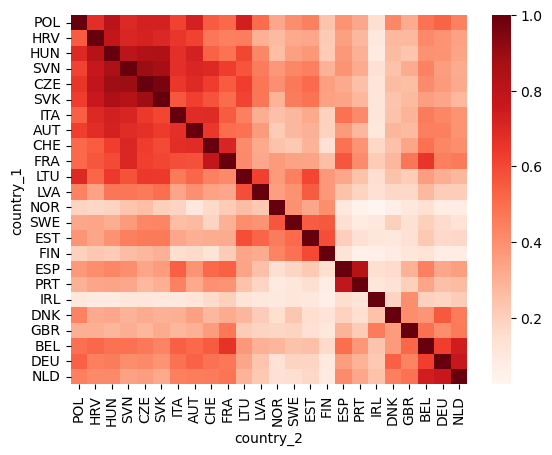

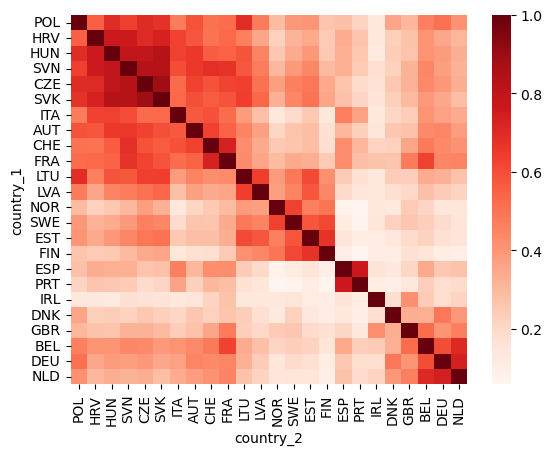

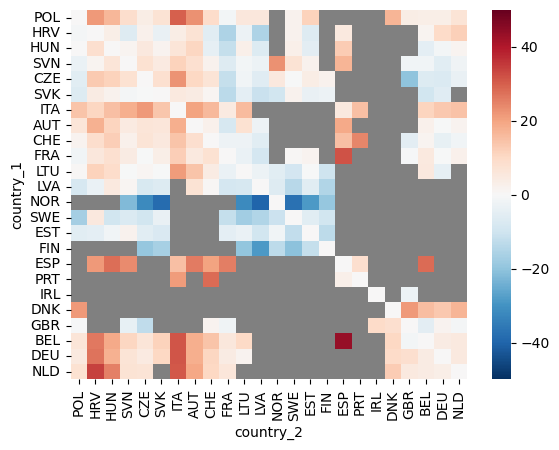

In [5]:
probs_table, base_rates = count_to_salton(counts_df_wr, np.array(COUNTRIES)[ROW_ORDER])
probs_table_clim, base_rates_clim = count_to_salton(co_occur_counts_df, np.array(COUNTRIES)[ROW_ORDER])
masked_probs_table_clim = np.where(probs_table_clim < 0.3, np.nan, probs_table_clim)

diff = 100 * (probs_table - masked_probs_table_clim) / probs_table_clim

plt.figure()
sns.heatmap(probs_table, cmap = 'Reds')
plt.figure()
sns.heatmap(probs_table_clim, cmap = 'Reds')
plt.figure()
sns.heatmap(diff, cmap = CMAP_GREY, vmin = -50, vmax = 50)

### Method 2. Conditional probability

In [6]:
def count_to_conditional(co_occur_count_df, country_order):
    pivot_table = (
        co_occur_count_df.pivot(index="country_1", columns="country_2", values="count")
        .reindex(country_order)
        .reindex(columns=country_order)
    )

    base_rates = np.diag(pivot_table).copy()

    conditional = pivot_table / base_rates[:, np.newaxis]
    return conditional, base_rates

In [10]:
counts_df_wr

,country_1,country_2,count
0,AUT,AUT,493
1,AUT,BEL,275
2,AUT,CHE,291
3,AUT,CZE,304
4,AUT,DEU,282
...,...,...,...
571,SWE,POL,107
572,SWE,PRT,25
573,SWE,SVK,114
574,SWE,SVN,97


In [50]:
np.isnan(base_rates_mask)

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False, False, False, False])

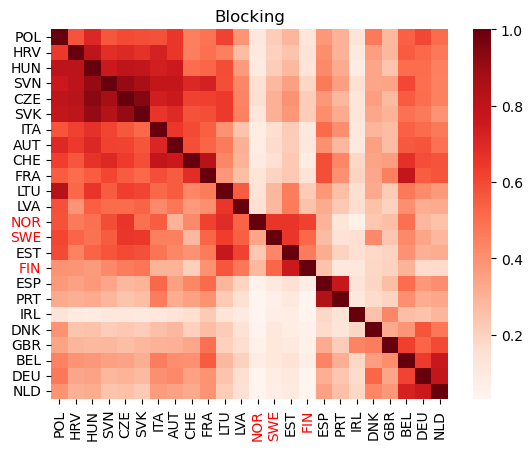

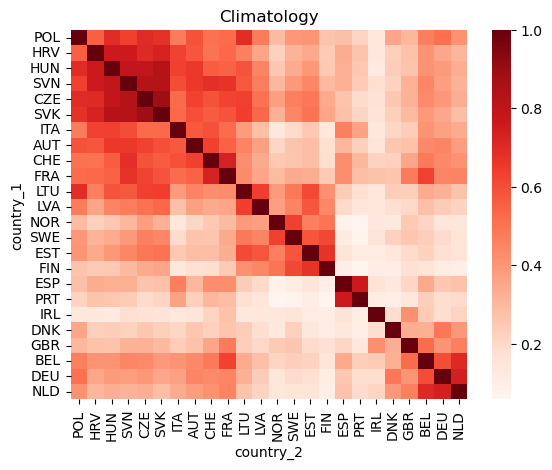

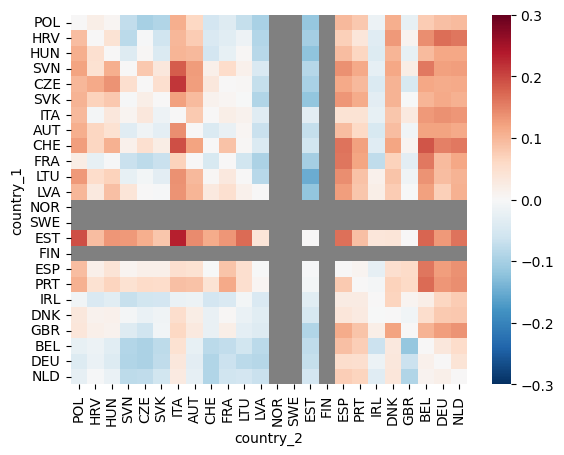

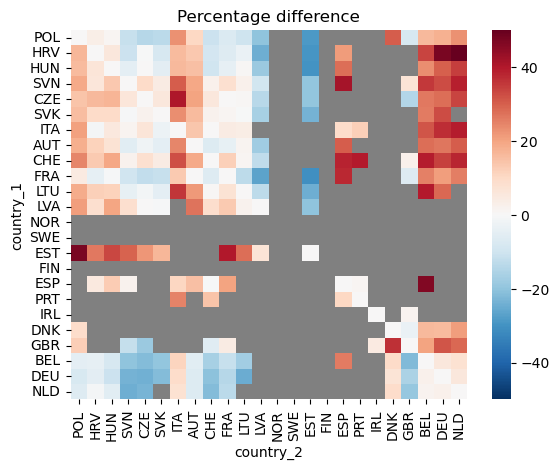

In [58]:
conditional, base_rates_2 = count_to_conditional(counts_df_wr, np.array(COUNTRIES)[ROW_ORDER])
base_rates_mask = np.where(base_rates_2 <= 200, np.nan, 1)
conditional_mask = np.outer(base_rates_mask, base_rates_mask)
conditional_clim, base_rates_clim = count_to_conditional(co_occur_counts_df, np.array(COUNTRIES)[ROW_ORDER])
masked_conditional_clim = np.where(conditional_clim < 0.3, np.nan, conditional_clim)
diff = 100 * (conditional - masked_conditional_clim) / conditional_clim

plt.figure()
ax = sns.heatmap(conditional.values, cmap = 'Reds', xticklabels = np.array(COUNTRIES)[ROW_ORDER], yticklabels = np.array(COUNTRIES)[ROW_ORDER])
plt.title('Blocking')

# Color countries with low base rates in red, to indicate that the conditional probabilities are less reliable
for (x_label, y_label), mask in zip(zip(ax.get_xticklabels(), ax.get_yticklabels()), base_rates_mask):
    color = 'red' if np.isnan(mask) else 'black'
    x_label.set_color(color)
    y_label.set_color(color)

plt.figure()
sns.heatmap(conditional_clim, cmap = 'Reds')
plt.title('Climatology')

plt.figure()
sns.heatmap((conditional - conditional_clim)*conditional_mask, cmap = CMAP_GREY, vmin = -.3, vmax = .3)

plt.figure()
ax = sns.heatmap(diff*conditional_mask, cmap = CMAP_GREY, vmin = -50, vmax = 50)
plt.title('Percentage difference')
# Color countries with low base rates in red, to indicate that the conditional probabilities are less reliable
for (x_label, y_label), mask in zip(zip(ax.get_xticklabels(), ax.get_yticklabels()), base_rates_mask):
    color = 'red' if mask == 0 else 'black'
    x_label.set_color(color)
    y_label.set_color(color)

### Method 3. Relative co-occurrence w.r.t chance

In [8]:
def count_to_chance_ratio(co_occur_count_df, country_order):
    pivot_table = (
        co_occur_count_df.pivot(index="country_1", columns="country_2", values="count")
        .reindex(country_order)
        .reindex(columns=country_order)
    )

    base_rates = np.diag(pivot_table)
    denominator_matrix = np.outer(base_rates, base_rates)
    chance_ratio = NUM_EVENTS * pivot_table / denominator_matrix
    np.fill_diagonal(chance_ratio.values, np.nan)
    return chance_ratio, base_rates

<Axes: xlabel='country_2', ylabel='country_1'>

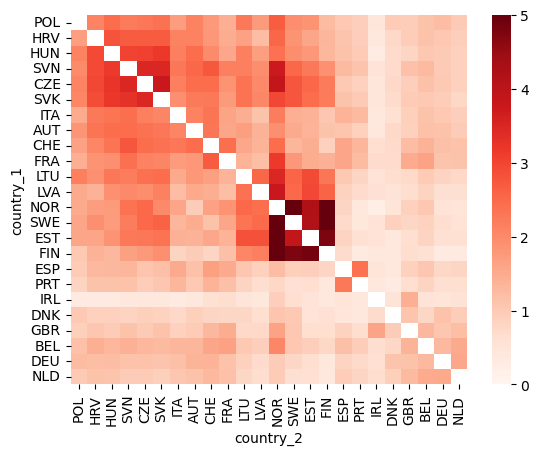

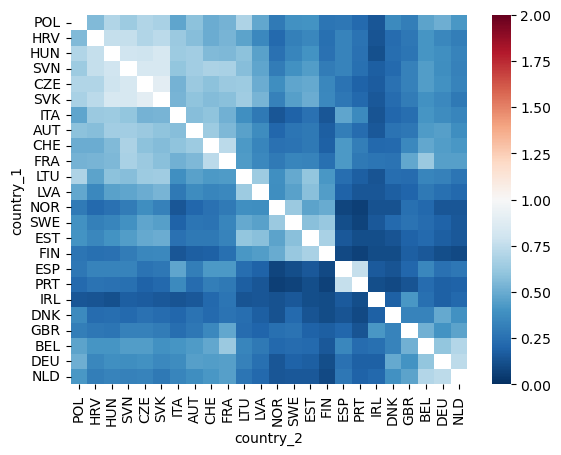

In [9]:
chance_ratio, base_rates_3 = count_to_chance_ratio(counts_df_wr, np.array(COUNTRIES)[ROW_ORDER])
clim_ratio, base_rates_clim = count_to_chance_ratio(co_occur_counts_df, np.array(COUNTRIES)[ROW_ORDER])

plt.figure()
sns.heatmap(chance_ratio, cmap = 'Reds', vmin = 0, vmax = 5)

plt.figure()
sns.heatmap(clim_ratio, cmap = 'RdBu_r', vmin = 0, vmax = 2)